In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
population_df = pd.read_excel('/home/jovyan/WorldCupHostCities_Impact/data/population_data.xlsx')
population_df.head()

,SEXO,CÓD.,SIGLA,LOCAL,2000,2001,2002,2003,2004,2005,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ambos,0,BR,Brasil,3423475,3347313,3274356,3212295,3163041,3123546,...,3012970,2948637,2883226,2920425,2885318,2777978,2688491,2597799,2527241,2484344
1,Ambos,0,BR,Brasil,3450022,3406966,3332612,3261091,3200484,3152623,...,2943154,3002376,2937001,2870232,2910089,2879163,2772134,2680031,2587620,2519770
2,Ambos,0,BR,Brasil,3461038,3444450,3401900,3327924,3256791,3196543,...,2907915,2936667,2995070,2928703,2863990,2906676,2876276,2767175,2673622,2583366
3,Ambos,0,BR,Brasil,3469109,3458052,3441638,3399284,3325501,3254582,...,2916787,2903600,2931742,2989393,2924609,2862071,2904924,2873055,2762809,2670309
4,Ambos,0,BR,Brasil,3477903,3466901,3455987,3439662,3397467,3323811,...,2898606,2913739,2900133,2927764,2986627,2923442,2861079,2902777,2869950,2760203


In [3]:
years = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,
         2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]

population_df = population_df.groupby('LOCAL', as_index=False)[years].sum()
print(population_df.shape)
population_df.head()

(33, 26)


,LOCAL,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Acre,1174652,1210654,1247074,1283862,1320844,1357858,1394740,1431066,1467208,...,1653354,1672588,1688992,1703008,1715838,1727314,1736692,1745132,1753164,1761262
1,Alagoas,5765322,5837220,5902966,5963482,6019824,6072304,6120334,6162008,6201260,...,6362356,6375812,6386310,6400256,6417408,6429646,6435638,6436762,6437214,6440208
2,Amapá,1001932,1045346,1087406,1128214,1167928,1206548,1242856,1277682,1311438,...,1494100,1513896,1531116,1545568,1558936,1571066,1581742,1590914,1598248,1605674
3,Amazonas,5701436,5842698,5981664,6119700,6258098,6397864,6540572,6684342,6828522,...,7718220,7829132,7932664,8036966,8146560,8242452,8320026,8399582,8481142,8562418
4,Bahia,26441334,26679804,26906098,27122164,27330768,27533008,27722576,27900344,28074422,...,28940894,29054152,29157384,29265304,29386500,29497102,29576540,29622678,29657612,29701026


In [4]:
states = [
    "Acre", "Alagoas", "Amapá", "Amazonas", "Bahia", "Ceará",
    "Distrito Federal", "Espírito Santo", "Goiás", "Maranhão",
    "Mato Grosso", "Mato Grosso do Sul", "Minas Gerais", "Paraná",
    "Paraíba", "Pará", "Pernambuco", "Piauí", "Rio Grande do Norte",
    "Rio Grande do Sul", "Rio de Janeiro", "Rondônia", "Roraima",
    "Santa Catarina", "Sergipe", "São Paulo", "Tocantins"
]

population_df = population_df[population_df['LOCAL'].isin(states)]
print(population_df.shape)
population_df.head()

(27, 26)


,LOCAL,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Acre,1174652,1210654,1247074,1283862,1320844,1357858,1394740,1431066,1467208,...,1653354,1672588,1688992,1703008,1715838,1727314,1736692,1745132,1753164,1761262
1,Alagoas,5765322,5837220,5902966,5963482,6019824,6072304,6120334,6162008,6201260,...,6362356,6375812,6386310,6400256,6417408,6429646,6435638,6436762,6437214,6440208
2,Amapá,1001932,1045346,1087406,1128214,1167928,1206548,1242856,1277682,1311438,...,1494100,1513896,1531116,1545568,1558936,1571066,1581742,1590914,1598248,1605674
3,Amazonas,5701436,5842698,5981664,6119700,6258098,6397864,6540572,6684342,6828522,...,7718220,7829132,7932664,8036966,8146560,8242452,8320026,8399582,8481142,8562418
4,Bahia,26441334,26679804,26906098,27122164,27330768,27533008,27722576,27900344,28074422,...,28940894,29054152,29157384,29265304,29386500,29497102,29576540,29622678,29657612,29701026


In [10]:
population_growth_df = population_df.drop('LOCAL', axis=1)
population_growth_df =population_growth_df.pct_change(axis=1) * 100
population_growth_df.insert(0, "STATE", population_df['LOCAL'])

population_growth_df.drop(2000, axis=1, inplace=True)
print(population_growth_df.shape)
population_growth_df.head()

(27, 25)


,STATE,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Acre,3.064908,3.008291,2.949945,2.880528,2.802299,2.716190,2.604500,2.525530,2.326323,...,1.367338,1.163332,0.980756,0.829844,0.753373,0.668828,0.542924,0.485981,0.460252,0.461908
1,Alagoas,1.247077,1.126324,1.025180,0.944784,0.871786,0.790968,0.680911,0.637000,0.569046,...,0.277300,0.211494,0.164654,0.218373,0.267989,0.190700,0.093193,0.017465,0.007022,0.046511
2,Amapá,4.333029,4.023548,3.752784,3.520077,3.306711,3.009246,2.802095,2.641972,2.537367,...,1.517497,1.324945,1.137463,0.943887,0.864925,0.778095,0.679539,0.579867,0.460993,0.464634
3,Amazonas,2.477657,2.378456,2.307652,2.261516,2.233362,2.230557,2.198126,2.156981,2.085166,...,1.607319,1.437015,1.322394,1.314842,1.363624,1.177086,0.941152,0.956199,0.971001,0.958314
4,Bahia,0.901883,0.848185,0.803037,0.769127,0.739972,0.688512,0.641239,0.623928,0.602399,...,0.422190,0.391342,0.355309,0.370129,0.414129,0.376370,0.269308,0.155995,0.117930,0.146384


In [11]:
print("\nMissing Values per Column:")
missing_values = population_growth_df.isnull().sum()
missing_values[missing_values > 0]


Missing Values per Column:


Series([], dtype: int64)

In [31]:
host_states = [
    "São Paulo","Rio de Janeiro","Amazonas","Distrito Federal",
    "Bahia","Ceará","Pernambuco","Rio Grande do Sul",
    "Paraná","Rio Grande do Norte","Mato Grosso","Minas Gerais"    
]

non_host_states = [
    "Acre","Alagoas","Amapá",           
    "Maranhão","Mato Grosso do Sul","Espírito Santo",  
    "Goiás","Paraíba","Pará","Piauí",           
    "Rondônia","Roraima","Santa Catarina",  
    "Sergipe","Tocantins"        
]

In [34]:
years_before_worldcup = [2001,2002,2003,2004,2005,2006,
                         2007,2008,2009,2010,2011,2012,2013]

population_growth_before_worldcup = population_growth_df[years_before_worldcup]
population_growth_before_worldcup.insert(0, "STATE", population_df['LOCAL'])

population_growth_before_worldcup.head()

,STATE,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,Acre,3.064908,3.008291,2.949945,2.880528,2.802299,2.716190,2.604500,2.525530,2.326323,1.911759,1.744004,1.711027,1.535593
1,Alagoas,1.247077,1.126324,1.025180,0.944784,0.871786,0.790968,0.680911,0.637000,0.569046,0.428154,0.336694,0.322962,0.328393
2,Amapá,4.333029,4.023548,3.752784,3.520077,3.306711,3.009246,2.802095,2.641972,2.537367,2.175927,1.860734,1.723138,1.686222
3,Amazonas,2.477657,2.378456,2.307652,2.261516,2.233362,2.230557,2.198126,2.156981,2.085166,1.886182,1.709537,1.695615,1.691736
4,Bahia,0.901883,0.848185,0.803037,0.769127,0.739972,0.688512,0.641239,0.623928,0.602399,0.465607,0.351971,0.389093,0.407015


In [37]:
# Reshape the DataFrame from wide to long format
long_df = population_growth_before_worldcup.melt(id_vars=['STATE'], var_name='YEAR', value_name='POPULATIONGROWTH')
long_df['YEAR'] = long_df['YEAR'].astype(int)  # Convert years to integers

# Separate host and non-host states
host_states_population_before_worldcup = long_df[long_df['STATE'].isin(host_states)]
non_host_states_population_before_worldcup = long_df[long_df['STATE'].isin(non_host_states)]

print(host_states_population_before_worldcup.shape)
print(non_host_states_population_before_worldcup.shape)

(156, 3)
(195, 3)


,STATE,YEAR,POPULATIONGROWTH
0,Acre,2001,3.064908
1,Alagoas,2001,1.247077
2,Amapá,2001,4.333029
7,Espírito Santo,2001,1.524609
8,Goiás,2001,2.167549


In [42]:
for idx, host_state in enumerate(host_states_population_before_worldcup['STATE'].unique()):
    print(idx, host_state)

0 Amazonas
1 Bahia
2 Ceará
3 Distrito Federal
4 Mato Grosso
5 Minas Gerais
6 Paraná
7 Pernambuco
8 Rio Grande do Norte
9 Rio Grande do Sul
10 Rio de Janeiro
11 São Paulo


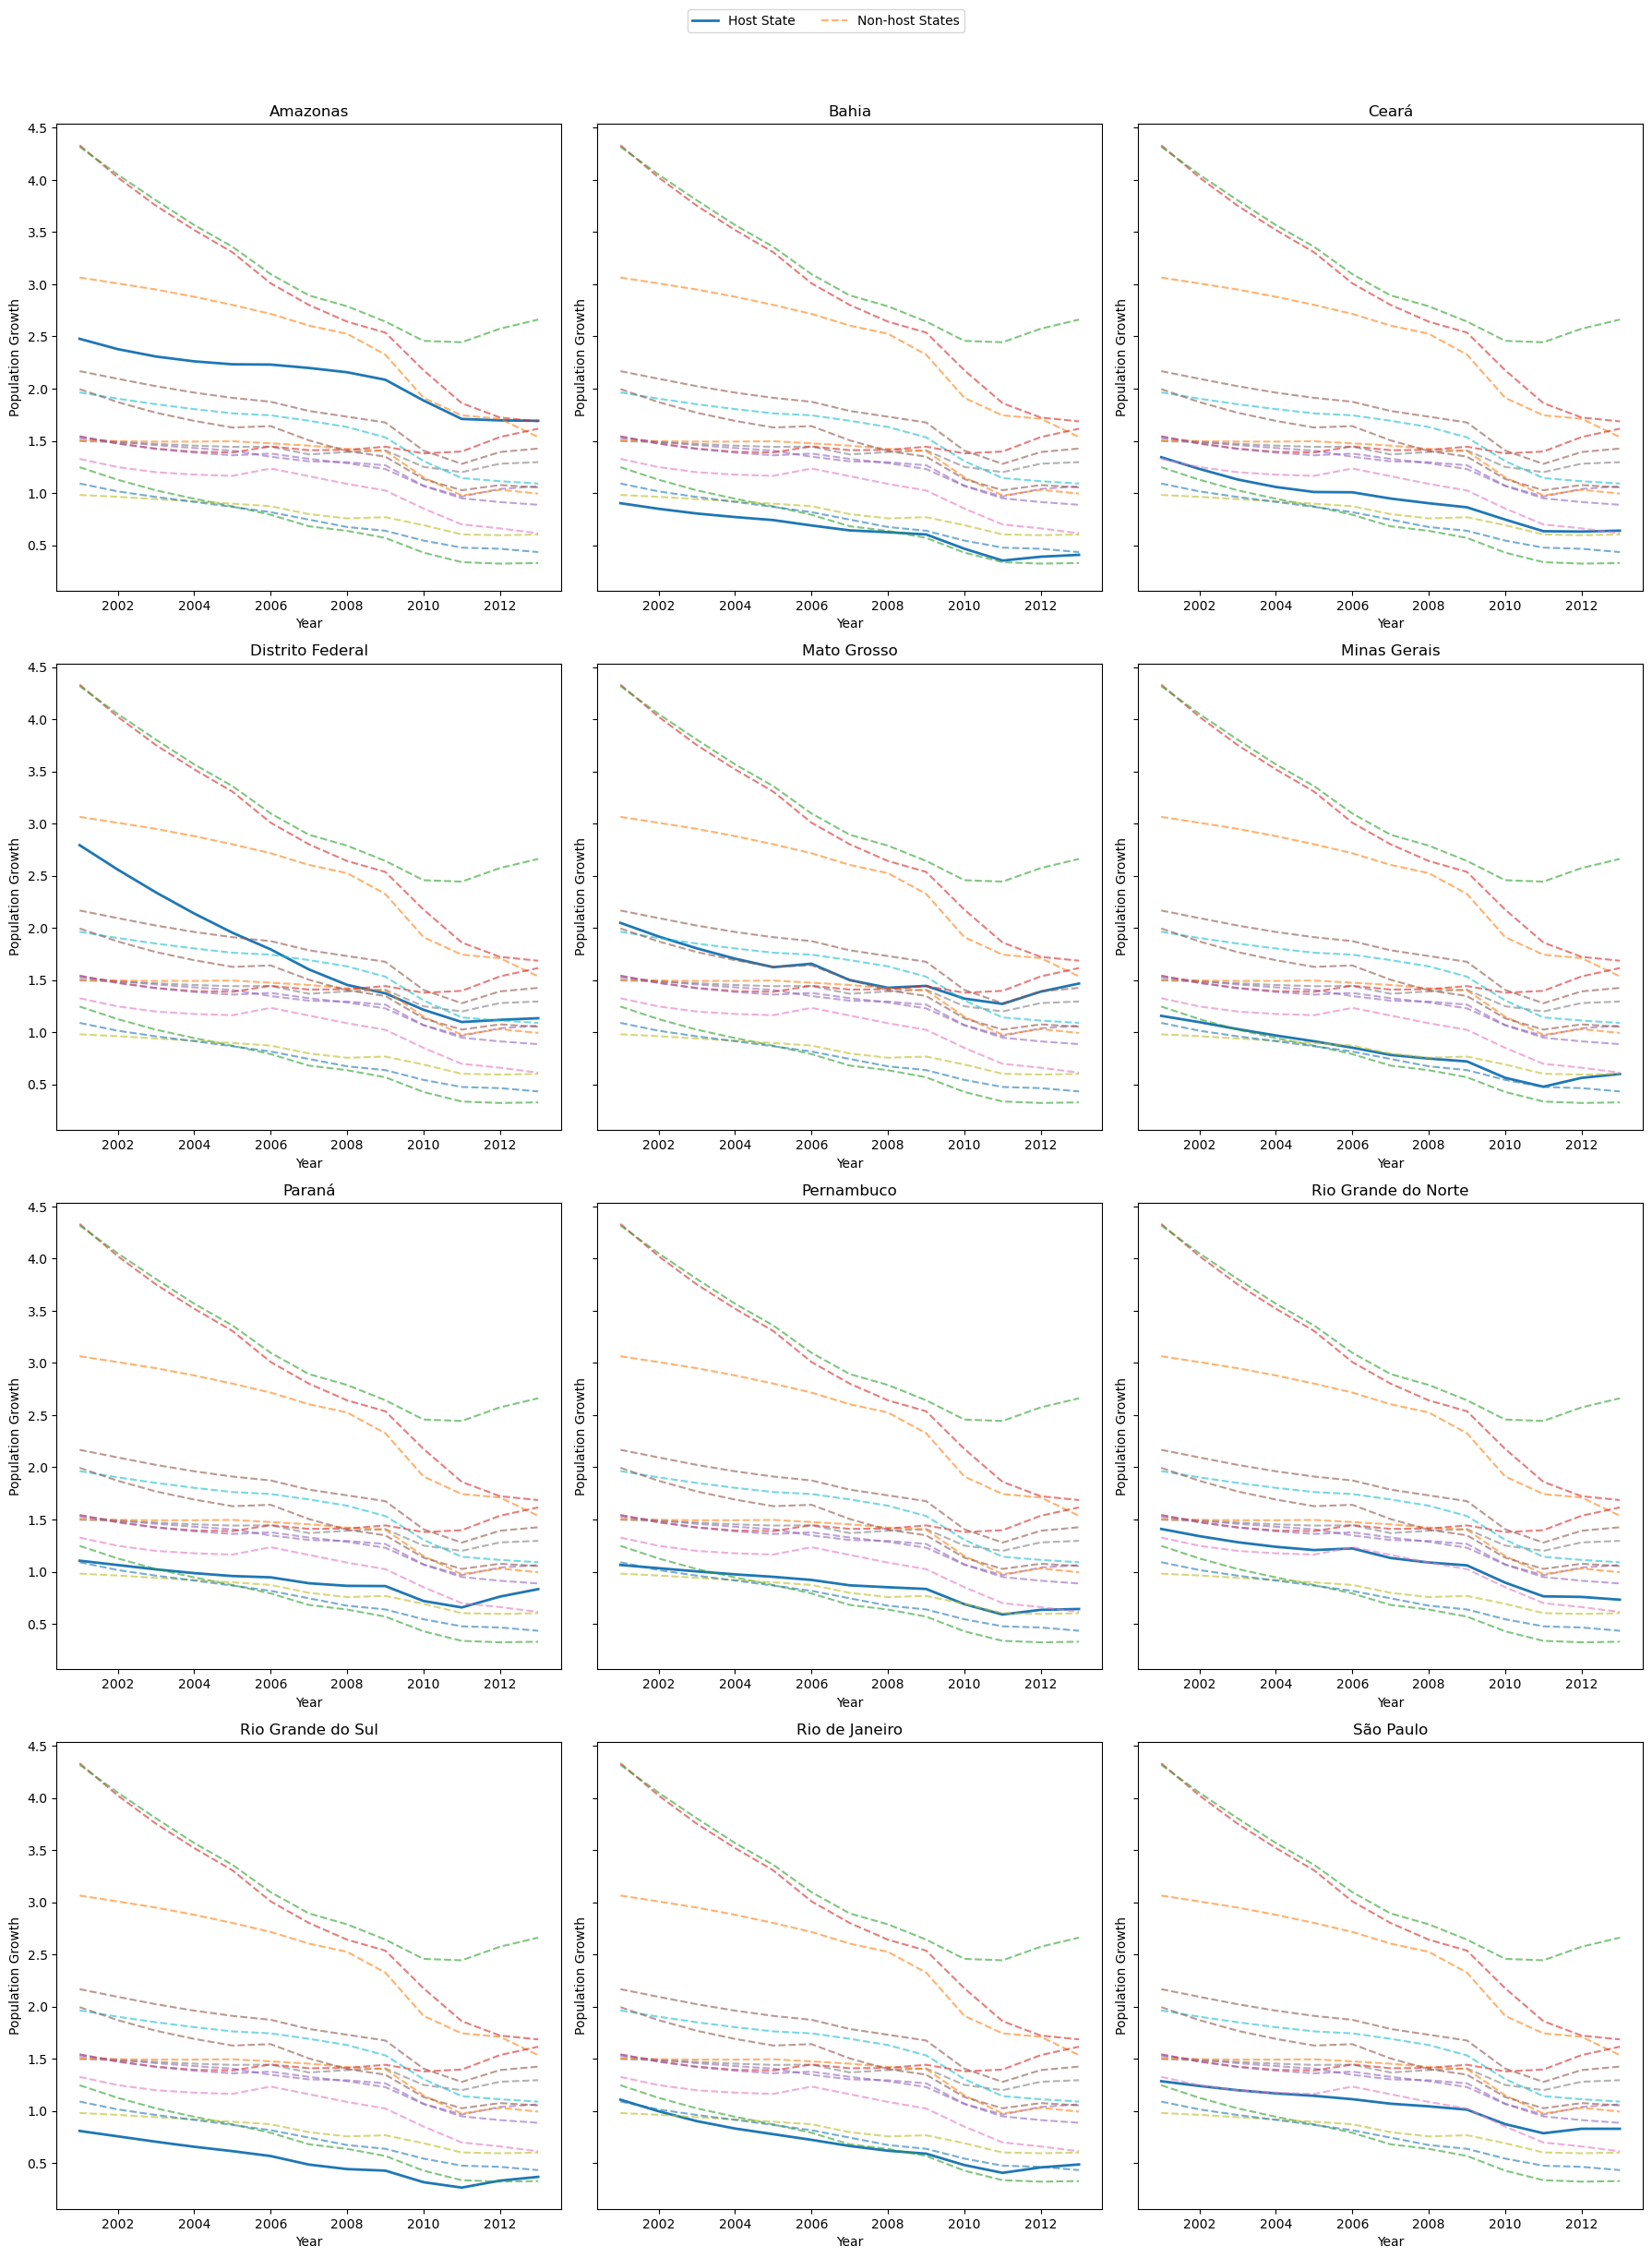

In [58]:
import numpy as np

# Calculate rows dynamically
rows = (num_host_states + 2) // 3

fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows), sharey=True)

# Flatten axes to a 1D array for consistent indexing
axes = np.array(axes).flatten()

# Collect handles and labels for a single legend
handles, labels = [], []

for id, state in enumerate(host_states_population_before_worldcup['STATE'].unique()):
    ax = axes[id]
    
    # Filter data for the specific host state
    host_data = host_states_population_before_worldcup[host_states_population_before_worldcup['STATE'] == state]
    
    # Plot host state population growth
    host_line, = ax.plot(
        host_data['YEAR'], host_data['POPULATIONGROWTH'], linewidth=2, label='Host State'
    )
    if 'Host State' not in labels:
        handles.append(host_line)
        labels.append('Host State')
    
    # Plot non-host states for comparison
    for non_host_state in non_host_states_population_before_worldcup['STATE'].unique():
        non_host_data = non_host_states_population_before_worldcup[non_host_states_population_before_worldcup['STATE'] == non_host_state]
        non_host_line, = ax.plot(
            non_host_data['YEAR'], non_host_data['POPULATIONGROWTH'], linestyle='--', alpha=0.6, label='Non-host States'
        )
        if 'Non-host States' not in labels:
            handles.append(non_host_line)
            labels.append('Non-host States')
    
    # Set title and labels for clarity
    ax.set_title(state)
    ax.set_xlabel("Year")
    ax.set_ylabel("Population Growth")
    
# Hide unused subplots
for id in range(len(host_states_population_before_worldcup['STATE'].unique()), len(axes)):
    axes[id].axis('off')

# Add a single legend outside the subplots
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize="medium", frameon=True, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to make space for the legend
plt.show()


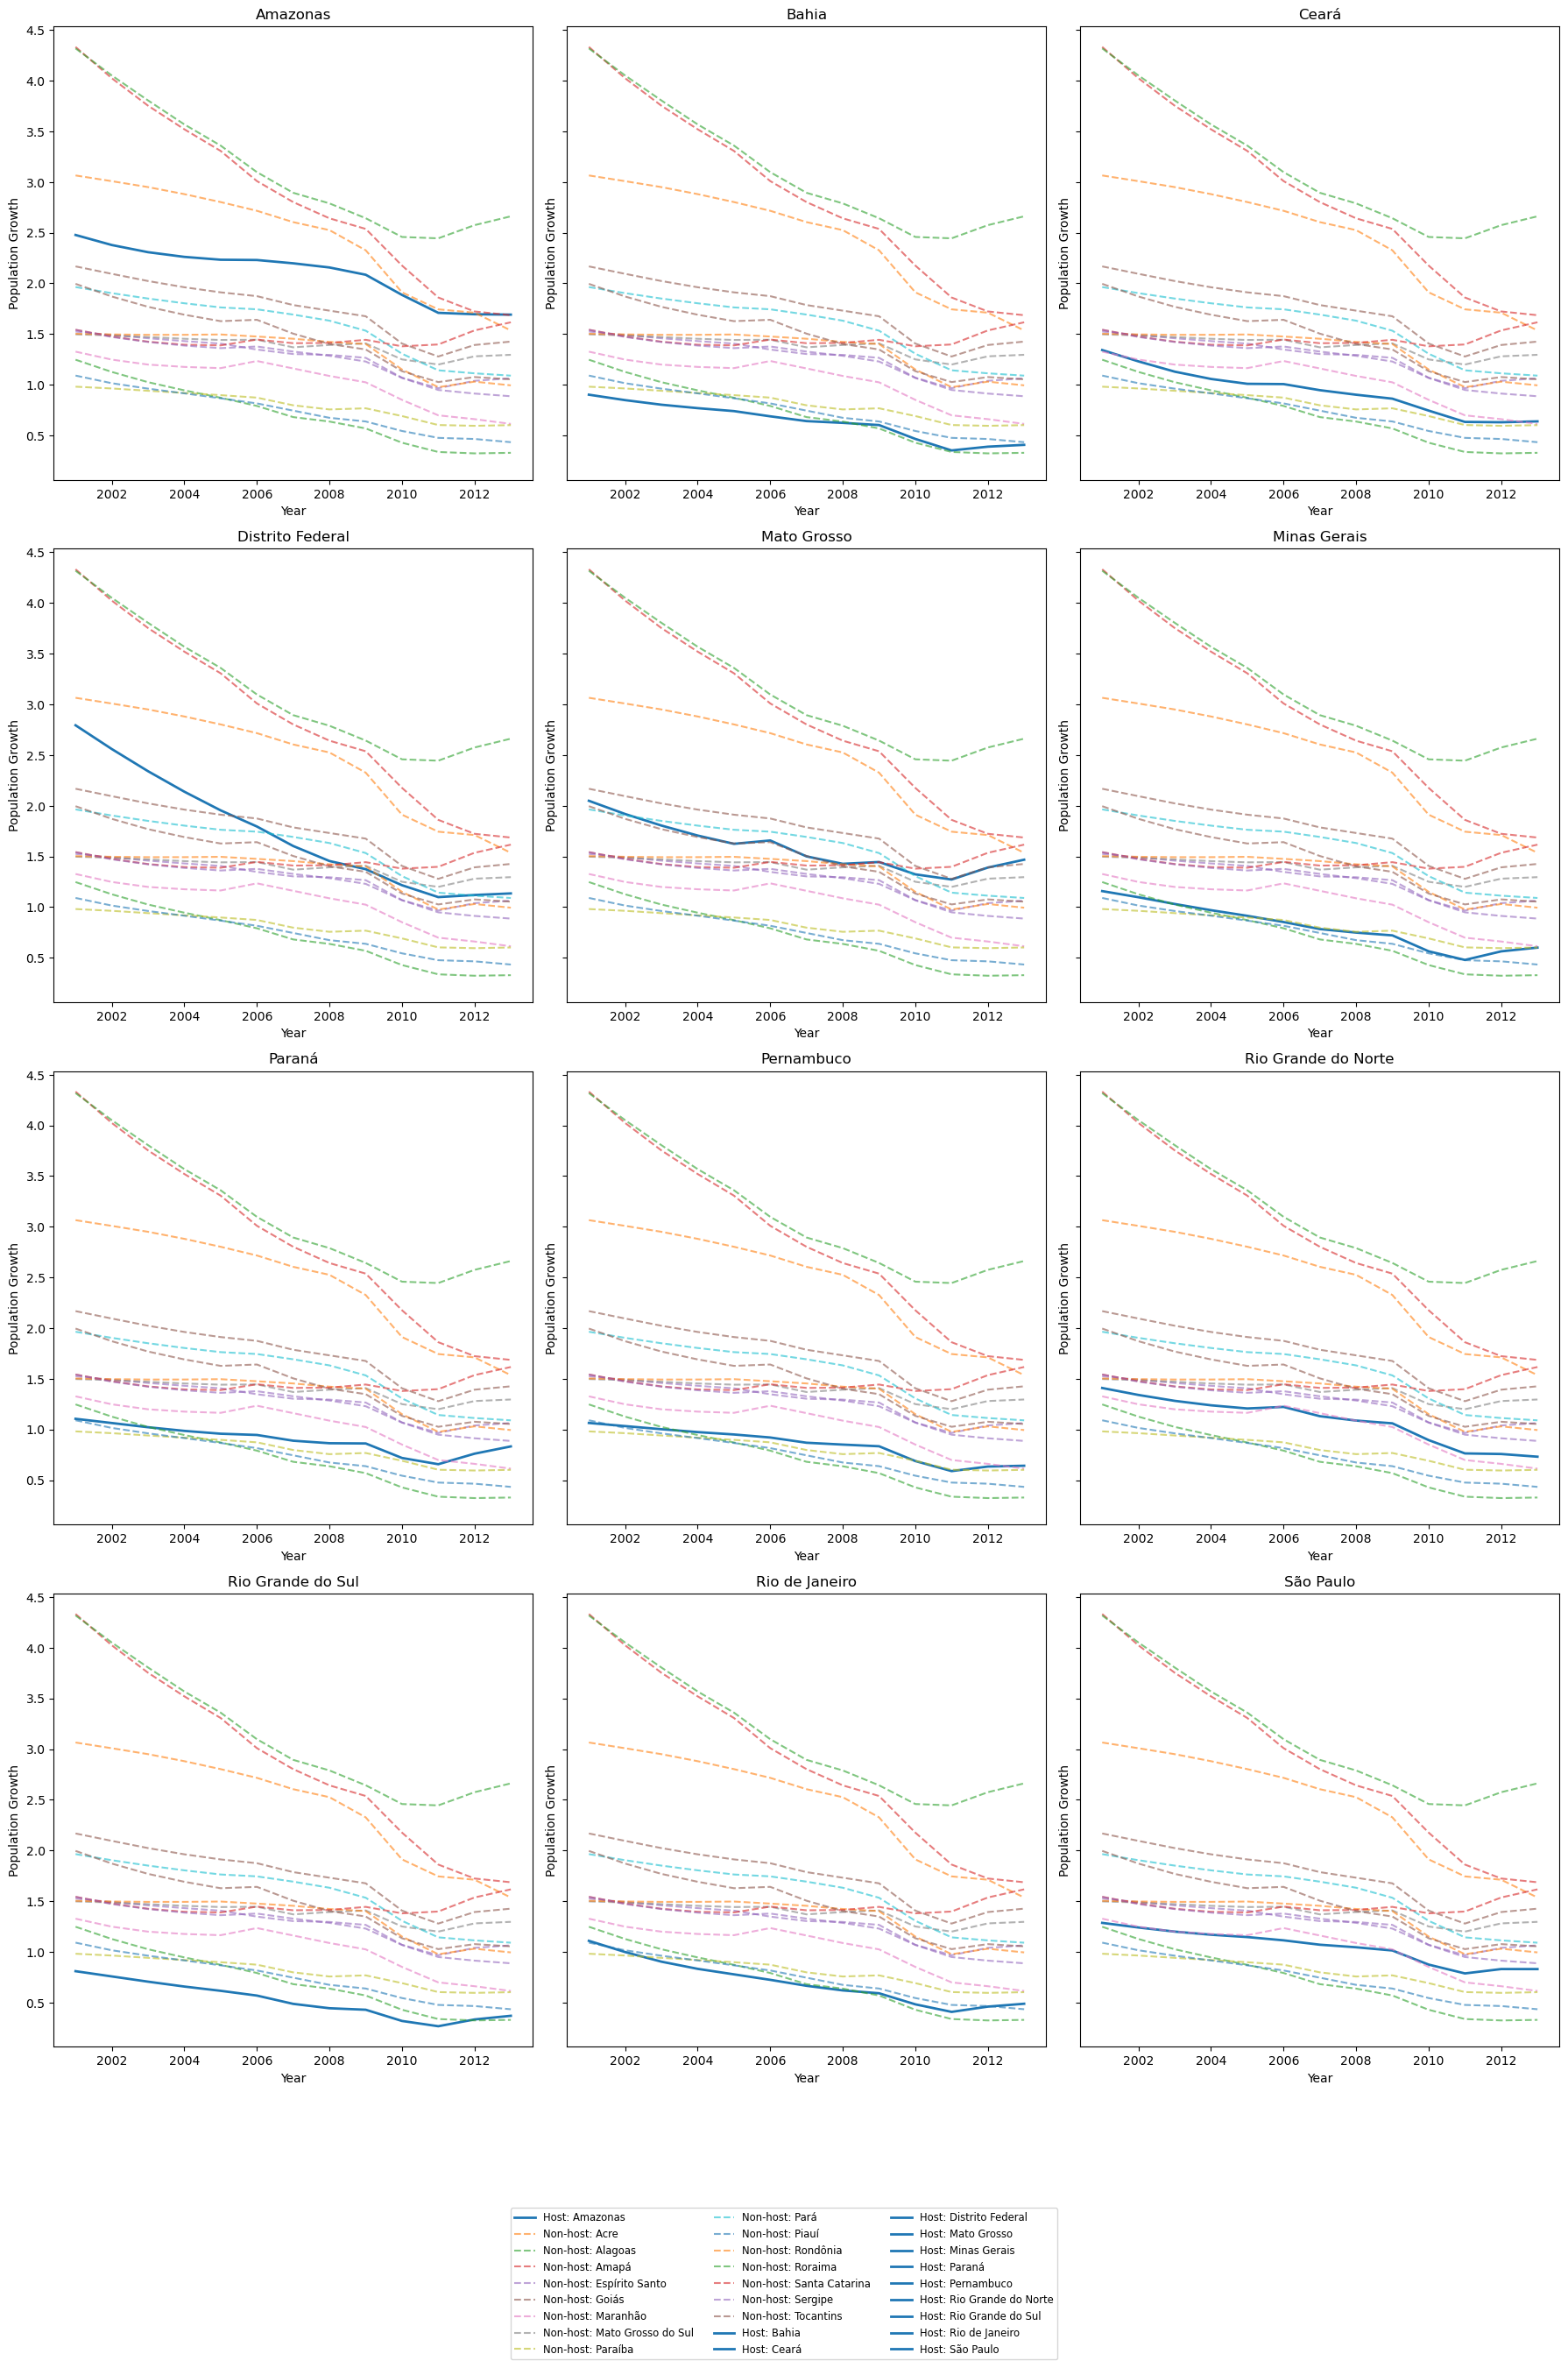

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate rows dynamically
rows = (num_host_states + 2) // 3

fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows), sharey=True)

# Flatten axes to a 1D array for consistent indexing
axes = np.array(axes).flatten()

# Keep track of handles and labels for a combined legend
handles = []
labels = []

for id, state in enumerate(host_states_population_before_worldcup['STATE'].unique()):
    ax = axes[id]
    
    # Filter data for the specific host state
    host_data = host_states_population_before_worldcup[host_states_population_before_worldcup['STATE'] == state]
    
    # Plot host state population growth
    host_line, = ax.plot(host_data['YEAR'], host_data['POPULATIONGROWTH'], 
                         linewidth=2, label=f'Host: {state}')
    
    # Add to legend tracking (only add once per type)
    if not any(lbl == host_line.get_label() for lbl in labels):
        handles.append(host_line)
        labels.append(host_line.get_label())
    
    # Plot non-host states for comparison
    for non_host_state in non_host_states_population_before_worldcup['STATE'].unique():
        non_host_data = non_host_states_population_before_worldcup[non_host_states_population_before_worldcup['STATE'] == non_host_state]
        non_host_line, = ax.plot(non_host_data['YEAR'], non_host_data['POPULATIONGROWTH'], 
                                 linestyle='--', alpha=0.6, label=f'Non-host: {non_host_state}')
        
        # Add to legend tracking (only add once per type)
        if not any(lbl == non_host_line.get_label() for lbl in labels):
            handles.append(non_host_line)
            labels.append(non_host_line.get_label())
    
    # Set title and labels for clarity
    ax.set_title(state)
    ax.set_xlabel("Year")
    ax.set_ylabel("Population Growth")
    
# Hide unused subplots
for id in range(len(host_states_population_before_worldcup['STATE'].unique()), len(axes)):
    axes[id].axis('off')

# Create a single legend outside the subplots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize="small")

plt.tight_layout()
plt.show()
